In [1]:
import numpy as np
import sys  
import unittest
sys.path.append('../')
from util.util import *
from keras.datasets import mnist
from util import importNotebook
from trial.autoencoder import VAE, ConvVAE

Using TensorFlow backend.


importing Jupyter notebook from ../trial/autoencoder.ipynb


In [2]:
class Test_util(unittest.TestCase):
    
    # Setting
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 4]
    layerConv = [4, 16]
    ratRecon = 1
    nameOptim = 'adam'
    modelPath = '../model/temp/'
    patience = 3

    # Load the dataset
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]
    dimInput = np.prod(sizeDigit)
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))

    # Train the model
    vae = VAE(dimInput, layerDense=layerDense, ratRecon=ratRecon)
    history, timeTrain = vae.fit(xTrain, xTest, 
                                 numEpochs=numEpochs,
                                 sizeBatch=sizeBatch,
                                 tempPathBest=modelPath)
    encoder = vae.encoder
    decoder = vae.decoder
    
    
    def test_compReconst(self):
        # the 1st case, the error should be 0
        x = np.array([[[1,2,3,4],[2,3,4,5]],
                      [[2,3,4,5],[3,4,5,6]],
                      [[3,4,5,6],[4,5,6,7]]])
        decode = np.array([[[1,2,3,4],[2,3,4,5]],
                          [[2,3,4,5],[3,4,5,6]],
                          [[3,4,5,6],[4,5,6,7]]])
        err = compReconst(x, decode)
        print(err)

        # the 2nd case, the error should be 0.2041241452319315
        x = np.array([[[1,2,3,4],[2,3,4,5]],
                      [[2,3,4,5],[3,4,5,6]],
                      [[3,4,5,6],[4,5,6,7]]])
        decode = np.array([[[1,2,3,4],[2,3,4,5]],
                           [[2,3,4,5],[3,4,5,6]],
                           [[3,4,5,6],[4,5,6,6]]])
        err = compReconst(x, decode)
        print(err)
        
        # the 3rd case for another shape, the error should be the same with the 2nd
        x = np.array([[[[1,2],[3,4]],[[2,3],[4,5]]],
                      [[[2,3],[4,5]],[[3,4],[5,6]]],
                      [[[3,4],[5,6]],[[4,5],[6,7]]]])
        decode = np.array([[[[1,2],[3,4]],[[2,3],[4,5]]],
                           [[[2,3],[4,5]],[[3,4],[5,6]]],
                           [[[3,4],[5,6]],[[4,5],[6,6]]]])
        err = compReconst(x, decode)
        print(err)
        
        # the 4th case, the error should be 0.4972182922592389
        x = np.array([[1,0,0],[0,1,0],[0,0,1]])
        decode = np.array([[0.9,0.5,0.5],[0.9,0.5,0.5],[0.9,0.5,0.5]])
        err = compReconst(x, decode, method='log_loss')
        print(err)
        
        # the 5th case, the error should be 2
        x = np.array([0,0,0,0])
        decode = np.array([0,-2,0,2])
        err = compReconst(x, decode, method='mse')
        print(err)
        
        # the 6th case, the error should be 1
        x = np.array([0,0,0,0])
        decode = np.array([0,-2,0,2])
        err = compReconst(x, decode, method='mae')
        print(err)
        
        
    def test_plotScatterEncode(self):
        encoder = self.encoder
        decoder = self.decoder
        yTest = self.yTest
        xTest = self.xTest
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        plotScatterEncode(encodeTest, yTest, ylim, xlim, numShow=10000, dimShow=[1, 0])
        xlim = (meanEncTest[2] - 4*stdEncTest[2], meanEncTest[2] + 4*stdEncTest[2])
        ylim = (meanEncTest[3] - 4*stdEncTest[3], meanEncTest[3] + 4*stdEncTest[3])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000, dimShow=[2, 3])
        xlim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        ylim = (meanEncTest[3] - 4*stdEncTest[3], meanEncTest[3] + 4*stdEncTest[3])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000, dimShow=[1, 3])
        
        # Test markersize
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000, markersize=2)

    def test_plotScatterDecode(self):
        encoder = self.encoder
        decoder = self.decoder
        sizeDigit = self.sizeDigit
        xTest = self.xTest
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the decoding results from the encoding scatter
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)
        plotScatterDecode(decoder, sizeDigit, ylim, xlim, dimShow=[1, 0])
        xlim = (meanEncTest[2] - 4*stdEncTest[2], meanEncTest[2] + 4*stdEncTest[2])
        ylim = (meanEncTest[3] - 4*stdEncTest[3], meanEncTest[3] + 4*stdEncTest[3])
        plotScatterDecode(decoder, sizeDigit, xlim, ylim, dimShow=[2, 3])
        xlim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        ylim = (meanEncTest[3] - 4*stdEncTest[3], meanEncTest[3] + 4*stdEncTest[3])
        plotScatterDecode(decoder, sizeDigit, xlim, ylim, dimShow=[1, 3])
        

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.2939 - val_loss: 0.2479

Epoch 00001: val_loss improved from inf to 0.24790, saving model to ../model/temp/Conv_AutoEncoder.01-0.29-0.25.hdf5
Epoch 2/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.2398 - val_loss: 0.2293

Epoch 00002: val_loss improved from 0.24790 to 0.22930, saving model to ../model/temp/Conv_AutoEncoder.02-0.24-0.23.hdf5
Epoch 3/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.2237 - val_loss: 0.2151

Epoch 00003: val_loss improved from 0.22930 to 0.21510, saving model to ../model/temp/Conv_AutoEncoder.03-0.22-0.22.hdf5
Epoch 4/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.2126 - val_loss: 0.2081

Epoch 00004: val_loss improved from 0.21510 to 0.20807, saving model to ../model/temp/Conv_AutoEncoder.04-0.21-0.21.hdf5
Epoch 5/10
60000/60000 [=====================

0.0
0.2041241452319315
0.2041241452319315
0.4972182922592389
2.0
1.0


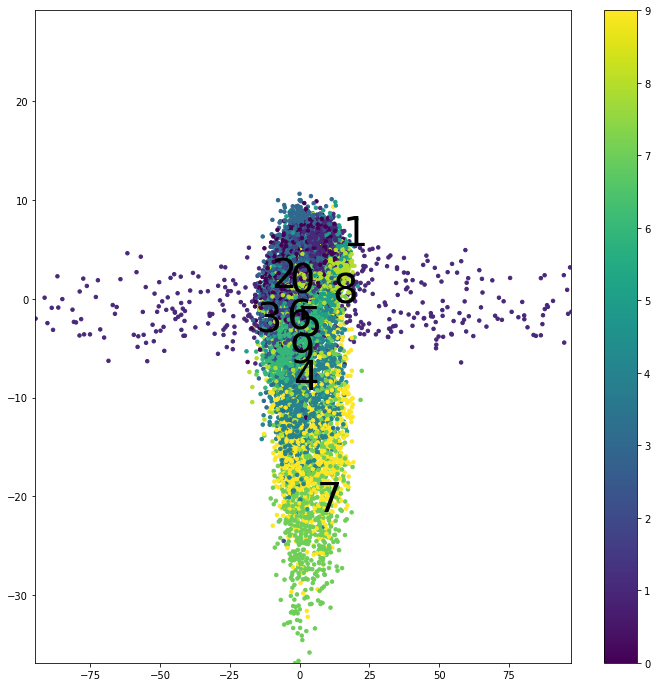

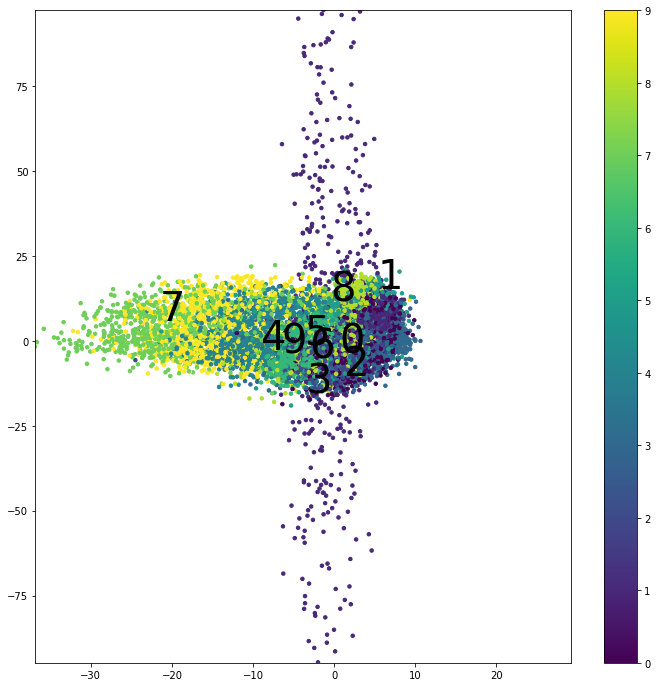

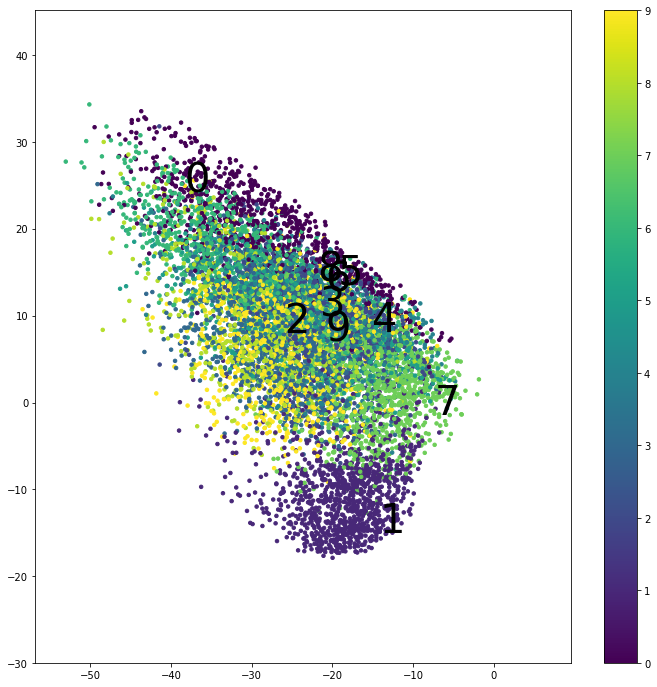

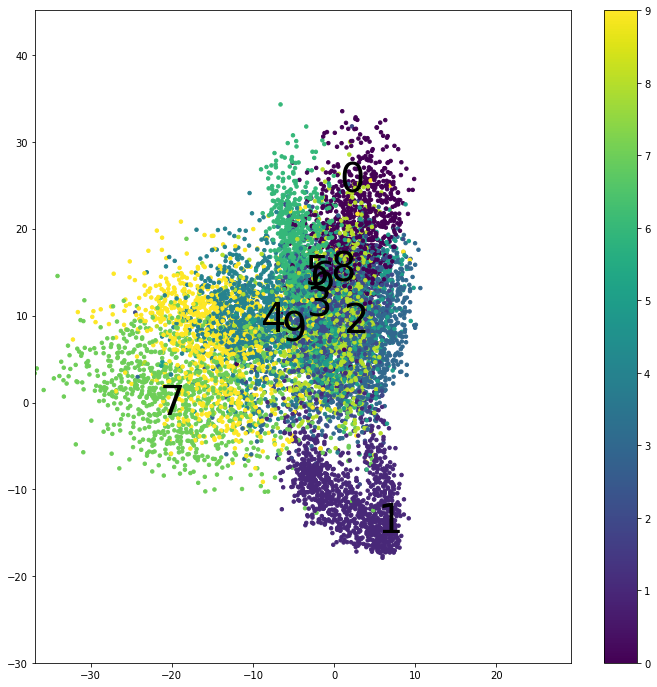

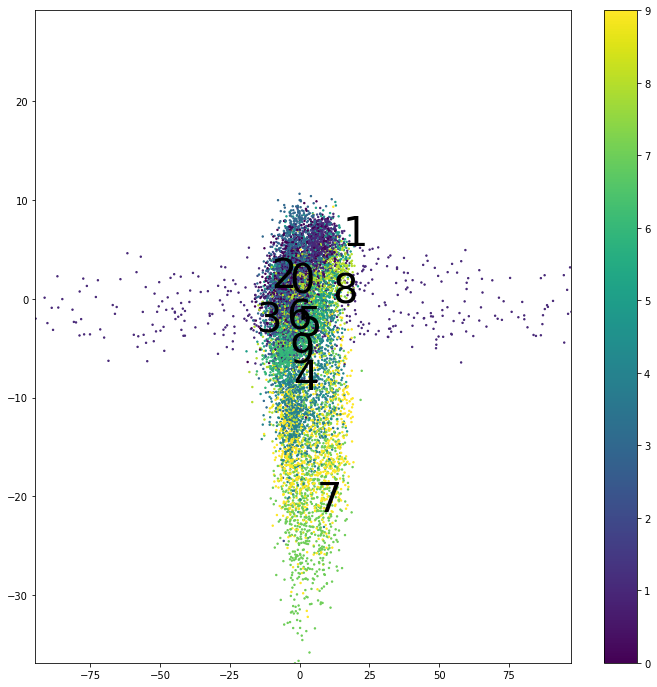

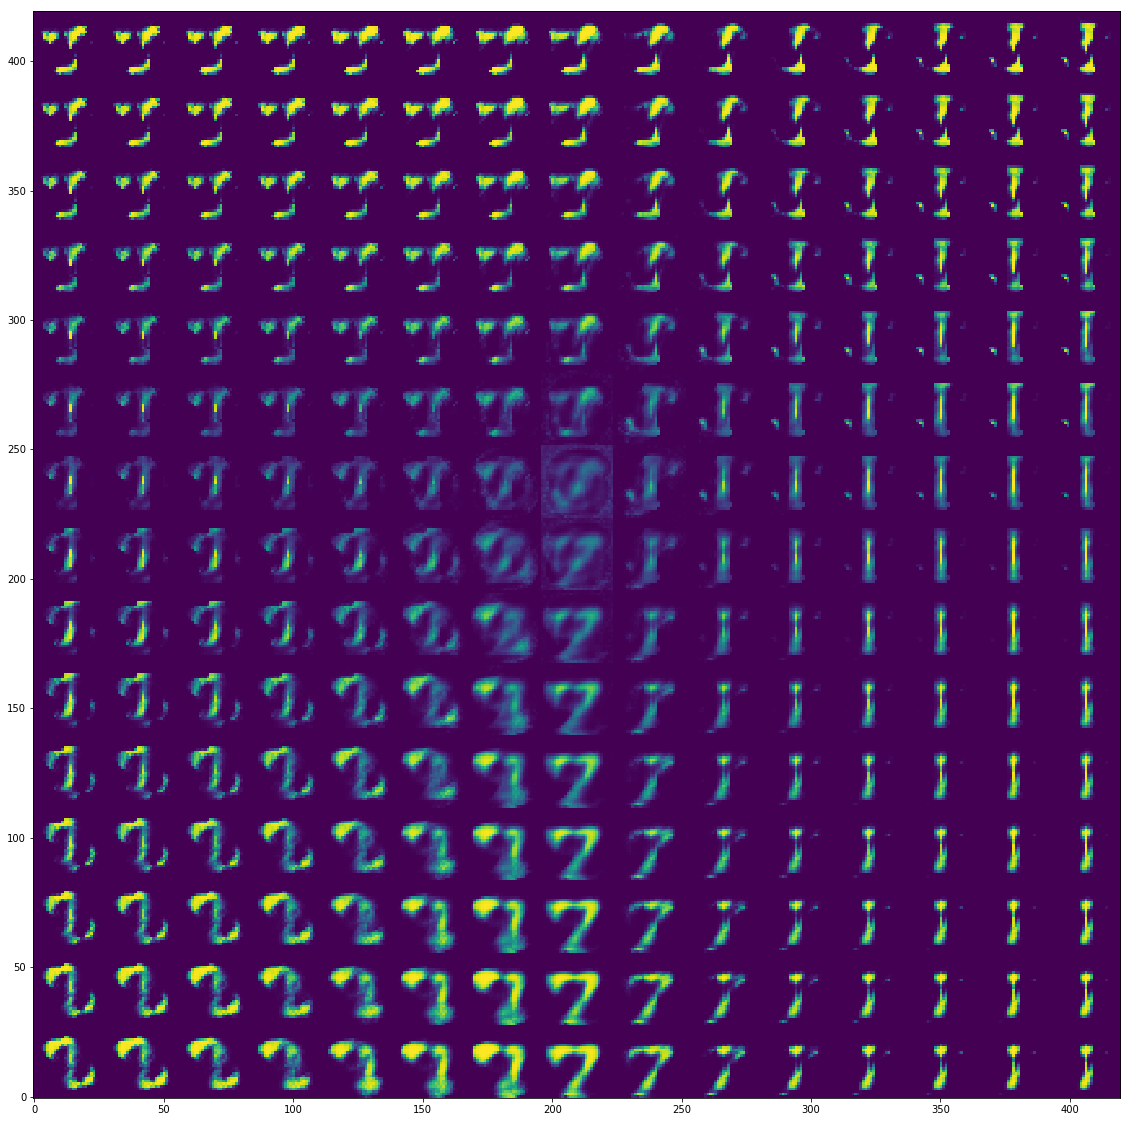

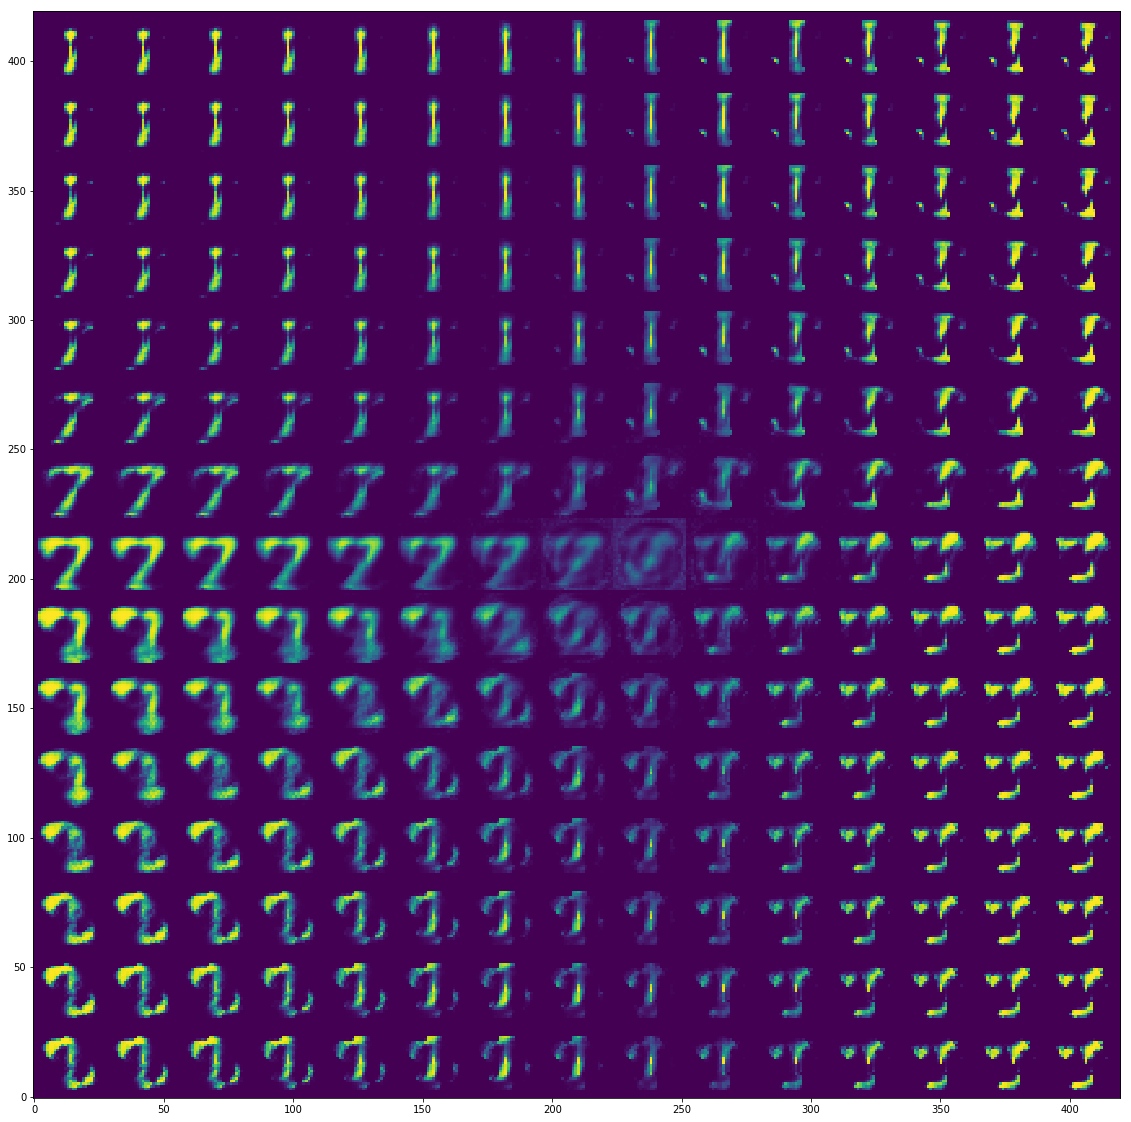

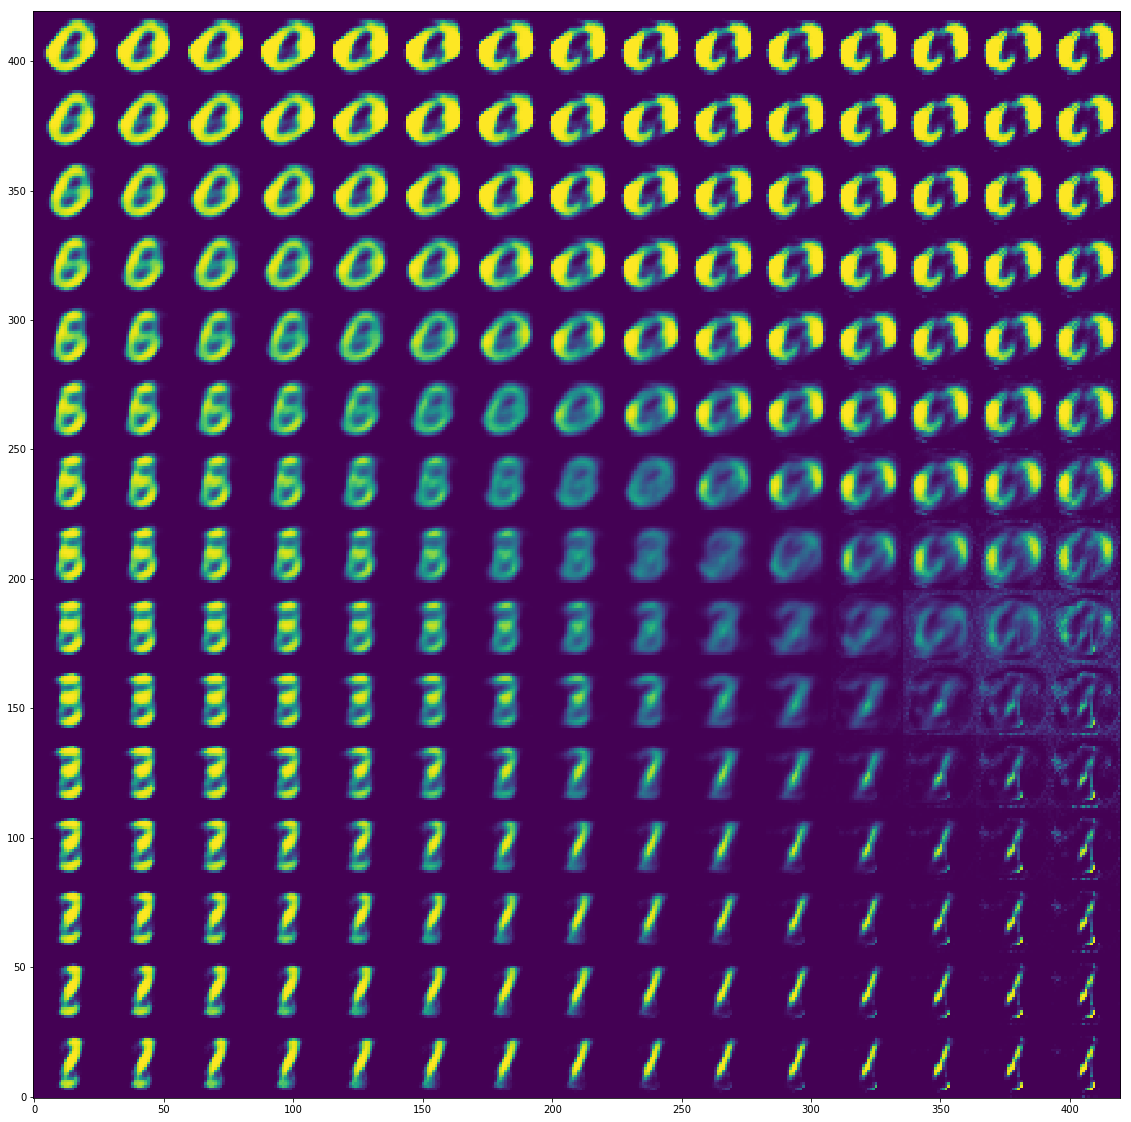

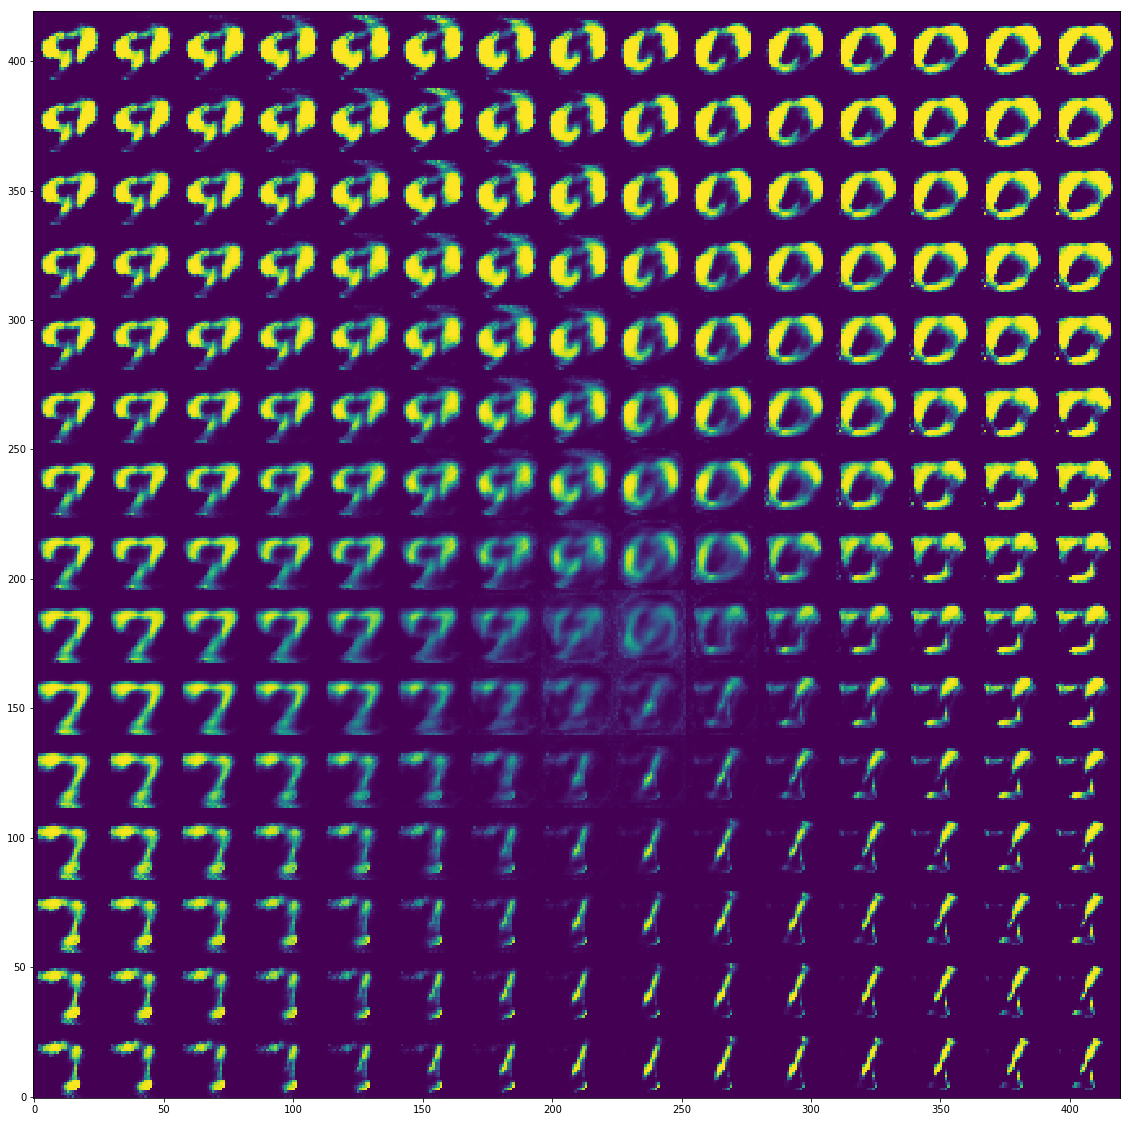

In [3]:
if __name__ == '__main__':
    test = Test_util()
    test.test_compReconst()
    test.test_plotScatterEncode()
    test.test_plotScatterDecode()